<a href="https://colab.research.google.com/github/psajaev1/COVID19Analysis/blob/master/CIS545project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
# COVID-19 Dataset 

In this notebook, I will be analyzing the JHU and NYT dataset for Covid-19. I got my code by navigating to the Covid19 github through the link that you guys gave us in the suggested data sets. <h5>
For my analysis, **I used the data up to and including May 1st**. <h5>
The downloaded data will include five different files. These files are: <h5>
1. df_all_cases
2. df_all_deaths
3. df_us_jhu 
4. df_us_nyt
5. df_us_combined

I included both domestic and international data but mostly focused on domestic data with my models only being predicted on the domestic data. 
I am be using the Sci-Kit learn library to create and train the model which will be predicting the daily growth of Corona Virus cases by each state. <h5>

For our purposes, we will only be looking at df_all_cases,df_all_deaths and df_us_combined. <h5> 

You can find these files here. https://github.com/willhaslett/covid-19-growth



# Note about my other working Google Colab NoteBook

This final notebook has the majority of the code that I had written for this project. Some things that this notebook does not include are the Apache Spark ML methods that I implemented such as Random Forest and Linear Regression. The order of everything is roughly the same with the Apache Spark ML portion being at the bottom of the notebook

# Importing Libraries and Setup 

We are just performing the usual set up Jargon here 

## Install libraries

Run these cells to install the necessary libraries for this notebook. Additionally, make sure to choose Java-8 when selecting the Java JDK.

In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u252-b09-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 


In [ ]:
### Install required packages
%%capture
!pip install pandasql


In [ ]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io 
import pandasql as ps

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import CSV files

Here we will create a folder in Google drive. We can then upload our CSV files to this folder. I ended up doing this manually by downloading them and moving them to this google drive folder. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# import downloaded CSV files
#Put them in this datacovid folder in google drive

path1 = "/content/drive/My Drive/datacovid/df_all_cases.csv"
path2 = "/content/drive/My Drive/datacovid/df_all_deaths.csv"
path3 = "/content/drive/My Drive/datacovid/df_us_combined.csv"
path4 = "/content/drive/My Drive/datacovid/df_us_jhu.csv"
path5 = "/content/drive/My Drive/datacovid/df_us_nyt.csv"

world_cases_df = pd.read_csv(path1)
world_deaths_df = pd.read_csv(path2)
us_combined_df = pd.read_csv(path3)
us_jhu_df = pd.read_csv(path4)
us_nyt_df = pd.read_csv(path5)

world_cases_df


,date,day,cases,province_state,country,lat,long
0,2020-01-22,0,0,NaN,Afghanistan,33.000000,65.000000
1,2020-01-22,0,0,NaN,Albania,41.153300,20.168300
2,2020-01-22,0,0,NaN,Algeria,28.033900,1.659600
3,2020-01-22,0,0,NaN,Andorra,42.506300,1.521800
4,2020-01-22,0,0,NaN,Angola,-11.202700,17.873900
...,...,...,...,...,...,...,...
26861,2020-05-01,100,6,NaN,Western Sahara,24.215500,-12.885800
26862,2020-05-01,100,16,NaN,Sao Tome and Principe,0.186360,6.613081
26863,2020-05-01,100,7,NaN,Yemen,15.552727,48.516388
26864,2020-05-01,100,1,NaN,Comoros,-11.645500,43.333300


## Setting up Local Connection to Apache Spark

We will now set up a connection to Apache Spark because we will be doing Apache Spark SQL to parse and get our desired data sets for the model. 

In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
--2020-05-07 01:27:38--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 40.79.78.1
Connecting to www-us.apache.org (www-us.apache.org)|40.79.78.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2020-05-07 01:27:38--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232530699 (222M) [application/x-gzip]
Savin

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev
!rm -rf yelp_*

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Fetched 252 kB in 2s (150 kB/s)
Reading package lists... Done
Building dependency tree       
Reading s

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('BIGDATAPROJECT').getOrCreate()


In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
import sqlite3


from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


# Exploratory Data Analysis on Global Data
Our international data is made up of two files. However there is very little difference between the two files. In fact, the only difference is that one file has a cases column and the other one has a deaths column. Everything else is the same including the order and the amount of rows in the dataset. <h5> 
In this section, we will see how the daily spread of the Corona Virus looks as well as see how Latitude would potentially affect the transmission of the virus. 

Let us first combine the international data and make a spark dataframe from it

In [ ]:
!java -version

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In the below cell, we will drop the province_state column from the data frame because it is empty for the majority of the rows. <h5>
We will then create comb_country_sdf which is a spark dataframe and convert it into a pandas dataframe called comb_country_pd. Since the cases and deaths columns are the total cases and total deaths up to that day for a given country, we will find the daily increase in total cases and deaths by iterating through the data set and subtracting the difference between two consecutive days to get the daily increases. 

In [ ]:
schema = StructType([
           StructField("date", DateType(), nullable=False),
           StructField("day", IntegerType(), nullable=False),
           StructField("cases", IntegerType(), nullable=False),
           StructField("country", StringType(), nullable=False),
           StructField("lat", FloatType(), nullable=False),
           StructField("long", FloatType(), nullable=False),
           StructField("deaths", IntegerType(), nullable=False)
         ])



world_comb_df = world_cases_df.drop(['province_state'], axis = 1)
world_comb_df['deaths'] = world_deaths_df['deaths']

world_comb_df['date'] = pd.to_datetime(world_comb_df.date)


world_sdf = spark.createDataFrame(world_comb_df, schema = schema)
world_sdf.show(5)



world_sdf.createOrReplaceTempView('world_sdf')

query = '''select day,sum(cases) as total_cases, sum(deaths) as total_deaths,country from world_sdf 
          group by country,day 
          order by country,day ASC  '''


comb_country_sdf = spark.sql(query)
comb_country_sdf.show(15)

comb_country_pd = comb_country_sdf.toPandas()

comb_country_pd

for ind, row in comb_country_pd.iterrows():

  if (comb_country_pd.at[ind,'day'] == 0): 
    comb_country_pd.at[ind,'daily_cases'] = comb_country_pd.at[ind,'total_cases'] 
    comb_country_pd.at[ind,'daily_deaths'] = comb_country_pd.at[ind,'total_deaths']
  else: 
    comb_country_pd.at[ind,'daily_cases'] = comb_country_pd.at[ind,'total_cases'] - comb_country_pd.at[ind - 1,'total_cases']
    comb_country_pd.at[ind,'daily_deaths'] = comb_country_pd.at[ind,'total_deaths'] - comb_country_pd.at[ind - 1,'total_deaths']

country_group_df = comb_country_pd.sort_values(by=['daily_deaths'])
country_group_df




world_mod_sdf = spark.createDataFrame(comb_country_pd)

world_mod_sdf.createOrReplaceTempView('world_mod_sdf')

query = '''select day, sum(total_cases) as global_cases, 
            sum(total_deaths) as global_deaths,
            sum(daily_cases) as global_daily_cases,
            sum(daily_deaths) as global_daily_deaths 
            from world_mod_sdf 
            group by day
            order by day ASC'''

world_total_sdf = spark.sql(query)
world_total_sdf.show(10)





+----------+---+-----+-----------+--------+-------+------+
|      date|day|cases|    country|     lat|   long|deaths|
+----------+---+-----+-----------+--------+-------+------+
|2020-01-22|  0|    0|Afghanistan|    33.0|   65.0|     0|
|2020-01-22|  0|    0|    Albania| 41.1533|20.1683|     0|
|2020-01-22|  0|    0|    Algeria| 28.0339| 1.6596|     0|
|2020-01-22|  0|    0|    Andorra| 42.5063| 1.5218|     0|
|2020-01-22|  0|    0|     Angola|-11.2027|17.8739|     0|
+----------+---+-----+-----------+--------+-------+------+
only showing top 5 rows

+---+-----------+------------+-----------+
|day|total_cases|total_deaths|    country|
+---+-----------+------------+-----------+
|  0|          0|           0|Afghanistan|
|  1|          0|           0|Afghanistan|
|  2|          0|           0|Afghanistan|
|  3|          0|           0|Afghanistan|
|  4|          0|           0|Afghanistan|
|  5|          0|           0|Afghanistan|
|  6|          0|           0|Afghanistan|
|  7|         

## Plots to determine world growth trends 

Below are some graphs that show the general trend and growth in global cases, global deaths, and daily increases for each of this. <h5>
I was curious to see how much a world wide quarantine would actually affect the growth of cases and as we can see from the third graph, it appears that it has stopped increasing as drastically in the past 30 days. This would roughly correspond to a quarantine start day of Late March to Early April which is when the majority of the world went on full lockdown. From looking at these graphs, I would say that a quarantine has indeed helped slow down the rate of transmission. <h5> 
Once again, day 1 corresponds to a **Jan 22nd** start and the last day is **May 1st**. 

Text(0, 0.5, 'Total amount')

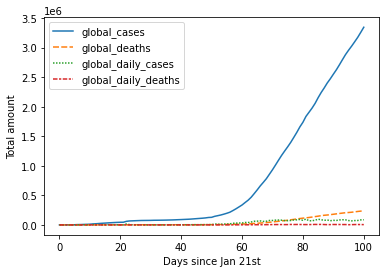

In [ ]:
#DATA VISUALIZATION 

world_total_df = world_total_sdf.toPandas()

graph_temp_df = world_total_df.drop(['day'],axis=1)

ax = sns.lineplot(data=graph_temp_df)

ax.set_xlabel("Days since Jan 21st")
ax.set_ylabel("Total amount")



Text(0, 0.5, 'Total amount')

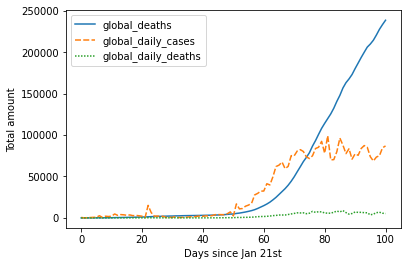

In [ ]:

graph_temp_df = world_total_df.drop(['global_cases', 'day'], axis=1)
ax = sns.lineplot(data=graph_temp_df)

ax.set_xlabel("Days since Jan 21st")
ax.set_ylabel("Total amount")
# from this graph it seems like that the quarantine that happened around the world worked 
# notice that the increase of global daily cases has decreased

Text(0, 0.5, 'Total amount')

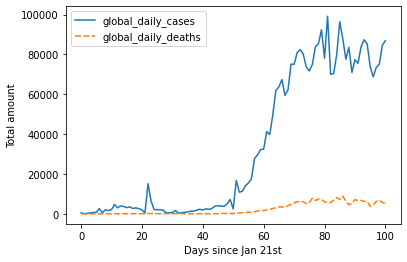

In [ ]:
graph_temp_df = world_total_df.drop(['global_cases', 'day','global_deaths'], axis=1)
ax = sns.lineplot(data=graph_temp_df)

ax.set_xlabel("Days since Jan 21st")
ax.set_ylabel("Total amount")

##Does Latitude affect Virus transimission

We will now try to see if temperature has any difference on Cornona Virus Transmission. I will assume that the closer you are to the equator, the warmer that the temperature is. We can measure this by looking at latitude. <h5> 
I grouped countries by latitude and by day. Since the latitudes varied widely, I used the absolute value of latitude as well as rounding each country's latitude to the nearest integer.  <h5> 
We will use the same methodology as above to calculate the daily increase in cases and deaths. 

In [ ]:
# world_comb_df is our base dataframe without provinces or world_sdf
# will round latitude to nearest degree first



query = '''select day,country,sum(cases) as global_cases, sum(deaths) as global_deaths, round(avg(lat)) as lat
            from world_sdf
            group by country,day
            order by country,day '''

temp_lat_sdf = spark.sql(query)

temp_lat_sdf.show(5)

temp_lat_df = temp_lat_sdf.toPandas()


for ind, row in temp_lat_df.iterrows():

  if (temp_lat_df.at[ind,'day'] == 0): 
    temp_lat_df.at[ind,'daily_cases'] = temp_lat_df.at[ind,'global_cases'] 
    temp_lat_df.at[ind,'daily_deaths'] = temp_lat_df.at[ind,'global_deaths']
  else: 
    temp_lat_df.at[ind,'daily_cases'] = temp_lat_df.at[ind,'global_cases'] - temp_lat_df.at[ind - 1,'global_cases']
    temp_lat_df.at[ind,'daily_deaths'] = temp_lat_df.at[ind,'global_deaths'] - temp_lat_df.at[ind - 1,'global_deaths']


temp_lat_sdf = spark.createDataFrame(temp_lat_df)


temp_lat_sdf.createOrReplaceTempView('temp_lat_sdf')

query2 = '''select day,sum(global_cases) as global_cases,sum(global_deaths) as global_deaths, 
            sum(daily_cases) as new_daily_cases, sum(daily_deaths) as new_daily_deaths,lat
             from temp_lat_sdf group by lat,day
             order by sum(global_cases) '''

temp2_lat_sdf = spark.sql(query2)
temp2_lat_sdf.show(10)

temp2_lat_sdf.createOrReplaceTempView('temp2_lat_sdf')

query3 = '''select day, sum(new_daily_cases) as new_daily_cases,
            sum(new_daily_deaths) as new_daily_deaths, abs(lat) as latitude 
            from temp2_lat_sdf group by abs(lat), day
            order by sum(new_daily_cases)'''

world_lat_sdf = spark.sql(query3)

world_lat_sdf.show(20)


world_lat_df = world_lat_sdf.toPandas()




+---+-----------+------------+-------------+----+
|day|    country|global_cases|global_deaths| lat|
+---+-----------+------------+-------------+----+
|  0|Afghanistan|           0|            0|33.0|
|  1|Afghanistan|           0|            0|33.0|
|  2|Afghanistan|           0|            0|33.0|
|  3|Afghanistan|           0|            0|33.0|
|  4|Afghanistan|           0|            0|33.0|
+---+-----------+------------+-------------+----+
only showing top 5 rows

+---+------------+-------------+---------------+----------------+-----+
|day|global_cases|global_deaths|new_daily_cases|new_daily_deaths|  lat|
+---+------------+-------------+---------------+----------------+-----+
| 32|           0|            0|            0.0|             0.0| -3.0|
|  5|           0|            0|            0.0|             0.0| 65.0|
|  6|           0|            0|            0.0|             0.0| 54.0|
| 23|           0|            0|            0.0|             0.0|-16.0|
| 20|           0|   

We will now create a correlation matrix to see if there is a relationship between the growth of the virus and the latitude.


                           day  new_daily_cases  new_daily_deaths      latitude
day               1.000000e+00         0.211097          0.221130  9.253802e-18
new_daily_cases   2.110966e-01         1.000000          0.874316  5.168805e-02
new_daily_deaths  2.211300e-01         0.874316          1.000000  2.979047e-02
latitude          9.253802e-18         0.051688          0.029790  1.000000e+00


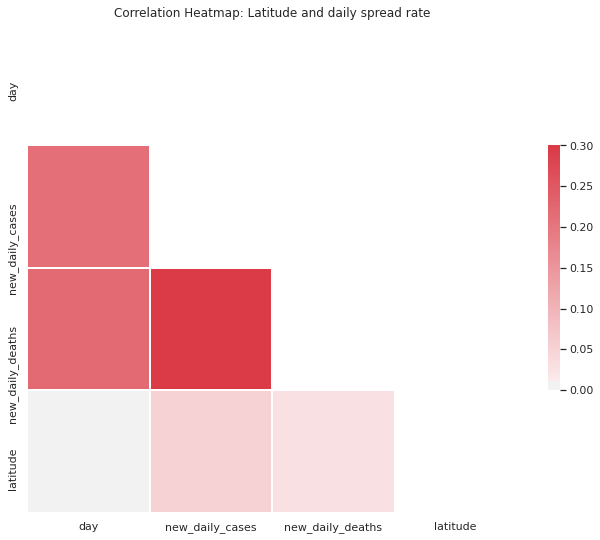

In [ ]:
correlation_matrix = world_lat_df.corr()
print(correlation_matrix)

sns.set(style="white")




corr = correlation_matrix

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Latitude and daily spread rate")
plt.show()

As we can see from the correlation map, it appears that there is no correlation between latitude and new daily cases and deaths. However, I believe that there is not enough data in order to make this a definitive statement. For example, we don't have access to the total population at each degree of latitude which would definitely affect the growth of cases. 

# Decision to use Domestic over Global data for modeling

While I thought that it would be interesting to see how the global spread rate of Corona was affected by quarantine, I did not think that there would be sufficient data to create a model from this. The US domestic dataset had over 5x the amount of entries as well as having columns for recovered and active cases. <h5> 
Additionally, there exists some data in the world data set that doesn't make sense such as Germany having a decrease of 10,000 total cases in one day. 

# Exploratory Data Analysis on Domestic Data

Since it seems like some of the world data might not be very accurate, we will also look at the domestic data and see if we can get any insights from it. <h5> 
We will look at the combined domestic data set since this is the same thing as df_us_jhu.csv and df_us_nyt.csv but they merged the columns together. An issue with this however, is that the JHU dataset starts on **March 22nd** while the New York times won starts on **Jan 21st**. <h5> 
To account for this, we will drop all rows with empty columns which will result in our dataset starting on March 22nd. The good thing though is that we end up losing only 5% of our dataset by dropping all the NaNs. 

In [ ]:
# let us drop all columns with Nan in it, esentially making it the combined data set
# let us also only look at the JHU dataset since the numbers are similar between the two but JHU includes recovered and active 
us_combined_df = us_combined_df.dropna()
us_combined_df['date'] = pd.to_datetime(us_combined_df.date)
us_combined_df.sort_values(by='cases_jhu', ascending=False)



,date,fips,day,county,state,sub_region,region,lat,long,cases_nyt,deaths_nyt,cases_jhu,deaths_jhu,recovered,active
103308,2020-05-01,17031,101,Cook,Illinois,east_north_central,midwest,41.841448,-87.816588,38668,1673,38668.0,1673.0,0.0,36995.0
100481,2020-04-30,17031,100,Cook,Illinois,east_north_central,midwest,41.841448,-87.816588,36513,1607,36513.0,1607.0,0.0,34906.0
104414,2020-05-01,36059,101,Nassau,New York,mid_atlantic,northeast,40.740665,-73.589419,36161,2140,36161.0,1720.0,0.0,34441.0
101580,2020-04-30,36059,100,Nassau,New York,mid_atlantic,northeast,40.740665,-73.589419,35854,2111,35854.0,1700.0,0.0,34154.0
98756,2020-04-29,36059,99,Nassau,New York,mid_atlantic,northeast,40.740665,-73.589419,35505,2077,35505.0,1678.0,0.0,33827.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14588,2020-03-27,26095,66,Luce,Michigan,east_north_central,midwest,46.472274,-85.544712,1,0,0.0,0.0,0.0,0.0
21465,2020-03-30,56017,69,Hot Springs,Wyoming,mountain,west,43.719307,-108.442317,1,0,0.0,0.0,0.0,0.0
10432,2020-03-24,47041,63,DeKalb,Tennessee,east_south_central,south,35.976163,-85.836894,1,0,0.0,0.0,0.0,0.0
19408,2020-03-29,56017,68,Hot Springs,Wyoming,mountain,west,43.719307,-108.442317,1,0,0.0,0.0,0.0,0.0


We will now shape the dataframe and get rid of any unuseful rows. In this case, we will only examine JHU data because it is the same as the NYT data but also includes recovered and active values.

In [ ]:

us_combined_df



,date,fips,day,county,state,sub_region,region,lat,long,cases_nyt,deaths_nyt,cases_jhu,deaths_jhu,recovered,active
7006,2020-03-22,1003,61,Baldwin,Alabama,east_south_central,south,30.727750,-87.722071,2,0,2.0,0.0,0.0,0.0
7007,2020-03-22,1015,61,Calhoun,Alabama,east_south_central,south,33.774837,-85.826304,1,0,1.0,0.0,0.0,0.0
7008,2020-03-22,1017,61,Chambers,Alabama,east_south_central,south,32.913601,-85.390727,2,0,2.0,0.0,0.0,0.0
7009,2020-03-22,1043,61,Cullman,Alabama,east_south_central,south,34.130203,-86.868880,2,0,2.0,0.0,0.0,0.0
7010,2020-03-22,1051,61,Elmore,Alabama,east_south_central,south,32.597854,-86.144153,6,0,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105574,2020-05-01,56035,101,Sublette,Wyoming,mountain,west,42.765583,-109.913092,1,0,3.0,0.0,0.0,3.0
105575,2020-05-01,56037,101,Sweetwater,Wyoming,mountain,west,41.659439,-108.882788,11,0,18.0,0.0,0.0,18.0
105576,2020-05-01,56039,101,Teton,Wyoming,mountain,west,43.935225,-110.589080,65,1,96.0,0.0,0.0,96.0
105577,2020-05-01,56041,101,Uinta,Wyoming,mountain,west,41.287818,-110.547578,6,0,8.0,0.0,0.0,8.0


## Searching for daily relationships by sub region

Let us now group the data together into different sub regions and see if we can find anything interesting. <h5>

Before doing this, let us find the daily increases in cases, deaths, recoveries and active cases. We will find this number using the same methodology as above for the global data. 

In [ ]:
us_combined_sdf = spark.createDataFrame(us_combined_df)


us_combined_sdf.createOrReplaceTempView('us_combined_sdf')



query = '''select *
            from us_combined_sdf
            order by state,county,day'''


temp_sub_region_sdf = spark.sql(query)
temp_sub_region_sdf.show(75)


temp_sub_region_df = temp_sub_region_sdf.toPandas()


for ind, row in temp_sub_region_df.iterrows():
  if(ind == 0):
    temp_sub_region_df.at[ind,'daily_cases'] = temp_sub_region_df.at[ind,'cases_jhu'] 
    temp_sub_region_df.at[ind,'daily_deaths'] = temp_sub_region_df.at[ind,'deaths_jhu']
    temp_sub_region_df.at[ind,'daily_recover'] = temp_sub_region_df.at[ind,'recovered']
    temp_sub_region_df.at[ind,'daily_active'] = temp_sub_region_df.at[ind,'active']

  elif (temp_sub_region_df.at[ind,'county'] != temp_sub_region_df.at[ind-1,'county']): 
    temp_sub_region_df.at[ind,'daily_cases'] = temp_sub_region_df.at[ind,'cases_jhu'] 
    temp_sub_region_df.at[ind,'daily_deaths'] = temp_sub_region_df.at[ind,'deaths_jhu']
    temp_sub_region_df.at[ind,'daily_recover'] = temp_sub_region_df.at[ind,'recovered']
    temp_sub_region_df.at[ind,'daily_active'] = temp_sub_region_df.at[ind,'active']

  else: 
    temp_sub_region_df.at[ind,'daily_cases'] = temp_sub_region_df.at[ind,'cases_jhu'] - temp_sub_region_df.at[ind - 1,'cases_jhu']
    temp_sub_region_df.at[ind,'daily_deaths'] = temp_sub_region_df.at[ind,'deaths_jhu'] - temp_sub_region_df.at[ind - 1,'deaths_jhu']
    temp_sub_region_df.at[ind,'daily_recover'] = temp_sub_region_df.at[ind,'recovered'] - temp_sub_region_df.at[ind - 1,'recovered']
    temp_sub_region_df.at[ind,'daily_active'] = temp_sub_region_df.at[ind,'active'] - temp_sub_region_df.at[ind - 1,'active']


temp_sub_region_df.sort_values(by="daily_cases") 

+-------------------+----+---+-------+-------+------------------+------+-----------+------------+---------+----------+---------+----------+---------+------+
|               date|fips|day| county|  state|        sub_region|region|        lat|        long|cases_nyt|deaths_nyt|cases_jhu|deaths_jhu|recovered|active|
+-------------------+----+---+-------+-------+------------------+------+-----------+------------+---------+----------+---------+----------+---------+------+
|2020-03-24 00:00:00|1001| 63|Autauga|Alabama|east_south_central| south|32.53952745|-86.64408227|        1|         0|      1.0|       0.0|      0.0|   0.0|
|2020-03-25 00:00:00|1001| 64|Autauga|Alabama|east_south_central| south|32.53952745|-86.64408227|        4|         0|      4.0|       0.0|      0.0|   0.0|
|2020-03-26 00:00:00|1001| 65|Autauga|Alabama|east_south_central| south|32.53952745|-86.64408227|        6|         0|      6.0|       0.0|      0.0|   0.0|
|2020-03-27 00:00:00|1001| 66|Autauga|Alabama|east_south_c

,date,fips,day,county,state,sub_region,region,lat,long,cases_nyt,deaths_nyt,cases_jhu,deaths_jhu,recovered,active,daily_cases,daily_deaths,daily_recover,daily_active
58190,2020-04-23,36071,93,Orange,New York,mid_atlantic,northeast,41.403375,-74.302408,6816,190,6816.0,268.0,0.0,6548.0,-336.0,24.0,0.0,-360.0
58350,2020-04-23,36079,93,Putnam,New York,mid_atlantic,northeast,41.426301,-73.749655,615,41,615.0,7.0,0.0,608.0,-216.0,0.0,0.0,-216.0
76915,2020-04-17,47037,87,Davidson,Tennessee,east_south_central,south,36.170074,-86.786461,1597,20,1307.0,19.0,0.0,1288.0,-185.0,0.0,0.0,-185.0
76911,2020-04-13,47037,83,Davidson,Tennessee,east_south_central,south,36.170074,-86.786461,1385,16,1207.0,16.0,0.0,1191.0,-142.0,3.0,0.0,-145.0
3265,2020-04-09,4017,79,Navajo,Arizona,mountain,west,35.399771,-110.321898,286,7,286.0,1.0,0.0,0.0,-118.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59040,2020-03-22,36119,61,Westchester,New York,mid_atlantic,northeast,41.162784,-73.757417,1873,0,1873.0,0.0,0.0,0.0,1873.0,0.0,0.0,0.0
57953,2020-03-22,36059,61,Nassau,New York,mid_atlantic,northeast,40.740665,-73.589419,1900,7,1900.0,4.0,0.0,0.0,1900.0,4.0,0.0,0.0
57970,2020-04-08,36059,78,Nassau,New York,mid_atlantic,northeast,40.740665,-73.589419,18548,701,18548.0,500.0,0.0,0.0,1938.0,0.0,0.0,0.0
20772,2020-04-10,17031,80,Cook,Illinois,east_north_central,midwest,41.841448,-87.816588,12472,398,12472.0,399.0,0.0,0.0,1952.0,89.0,0.0,0.0




Let us now look at the daily trends by sub region and see if there is anything interesting. 

In [ ]:

us_combined_df = temp_sub_region_df
us_daily_sdf = spark.createDataFrame(us_combined_df)

us_daily_sdf.createOrReplaceTempView('us_daily_sdf')

query = '''select day, sub_region, sum(daily_cases) as cases_sub_region, 
          sum(daily_deaths) as deaths_sub_region, sum(daily_recover) as recover_sub_region,
           sum(daily_active) as active_sub_region from us_daily_sdf 
           group by day,sub_region
           order by cases_sub_region DESC'''

us_sub_region_sdf = spark.sql(query)

us_sub_region_sdf.show(25)



+---+------------+----------------+-----------------+------------------+-----------------+
|day|  sub_region|cases_sub_region|deaths_sub_region|recover_sub_region|active_sub_region|
+---+------------+----------------+-----------------+------------------+-----------------+
| 78|mid_atlantic|         11874.0|            525.0|               0.0|              0.0|
| 74|mid_atlantic|         11677.0|            315.0|               0.0|              0.0|
| 79|mid_atlantic|         11147.0|            531.0|               0.0|              0.0|
| 80|mid_atlantic|         10872.0|            501.0|               0.0|              0.0|
| 73|mid_atlantic|         10795.0|            216.0|               0.0|              0.0|
| 86|mid_atlantic|         10326.0|            616.0|               0.0|           9710.0|
| 95|mid_atlantic|         10160.0|            395.0|               0.0|           9765.0|
| 77|mid_atlantic|          9731.0|            766.0|               0.0|              0.0|

Below I made a graph for each column in the above dataframe separated by sub_region. There appears to be no strong patterns that can be identified for new daily cases and deaths. However, it always appears that the mid atlantic region has the most which would make sense because New York is located in the mid atlantic region. <h5> 
Possible reasons for these very inconsistent rates of growth is simply that it is difficult to gain accurate data on Covid-19 because not everybody gets symptoms from it and not everybody who has syptoms gets tested. <h5>
Another thing that I found interesting is that for every entry in the dataset, recovery is 0. This would mean that the recovery column is useless to us. Also, it appears that the active column is also 0 most of the time other than a very large jump that appears at around day 80. For these reasons, I think it would be best that we got rid of the recover and active columns. 

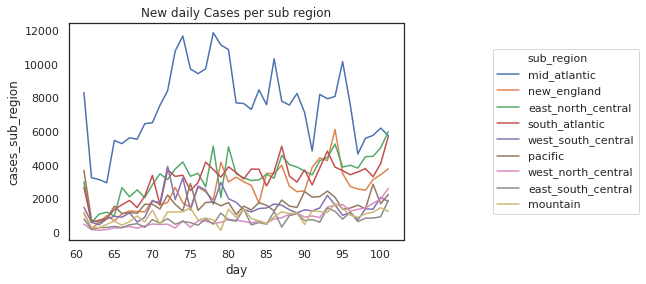

In [ ]:
us_sub_region_df = us_sub_region_sdf.toPandas()

#us_sub_region_df = us_sub_region_df.drop(['day'],axis=1)

sns.lineplot(x='day',y='cases_sub_region',data=us_sub_region_df, hue = 'sub_region').set(title='New daily Cases per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

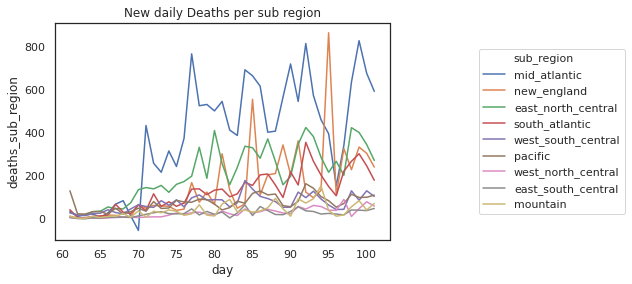

In [ ]:
sns.lineplot(x='day',y='deaths_sub_region',data=us_sub_region_df, hue = 'sub_region').set(title='New daily Deaths per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

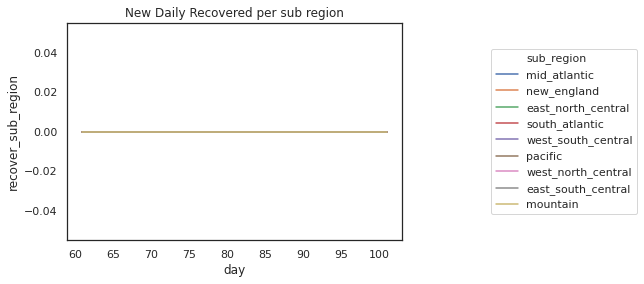

In [ ]:
sns.lineplot(x='day',y='recover_sub_region',data=us_sub_region_df, hue = 'sub_region').set(title='New Daily Recovered per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

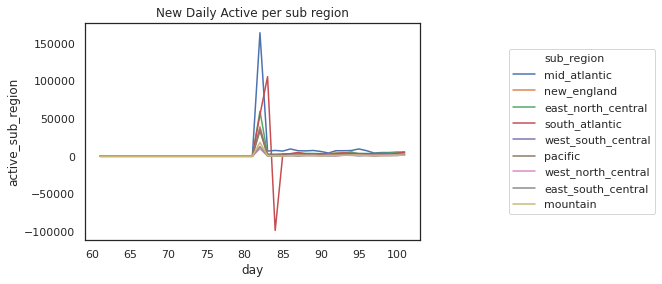

In [ ]:
sns.lineplot(x='day',y='active_sub_region',data=us_sub_region_df, hue = 'sub_region').set(title='New Daily Active per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

It seems like the daily statistics are remarkably inconsistent but there are some general trends that we can see. For example, there are generally more cases and deaths in the mid_atlantic area.

##Cumulative Data by sub region 

Just to make sure that everything makes sense, we will confirm that our cumulative cases and deaths make sense with our new daily cases and deaths from above. 

In [ ]:
query = '''select day, sub_region, sum(cases_jhu) as total_cases, 
            sum(deaths_jhu) as total_deaths
            from us_daily_sdf group by sub_region,day
              '''

us_cum_data_sdf = spark.sql(query)

us_cum_data_sdf.show(15)

us_cum_data_df = us_cum_data_sdf.toPandas()

+---+------------------+-----------+------------+
|day|        sub_region|total_cases|total_deaths|
+---+------------------+-----------+------------+
| 96|          mountain|    33803.0|      1370.0|
| 74|west_south_central|    20876.0|       573.0|
| 69|west_north_central|     2676.0|        40.0|
| 86|west_north_central|    12983.0|       415.0|
| 87|          mountain|    23258.0|       756.0|
| 75|west_south_central|    22215.0|       661.0|
| 72|      mid_atlantic|    68687.0|       924.0|
| 80|      mid_atlantic|   153954.0|      4395.0|
| 63|east_south_central|     1313.0|         7.0|
| 62|    south_atlantic|     3344.0|        48.0|
| 81|west_south_central|    36048.0|      1188.0|
| 74|           pacific|    21011.0|       630.0|
| 68|          mountain|     5132.0|        82.0|
| 63|east_north_central|     4736.0|        61.0|
| 78|    south_atlantic|    42559.0|       976.0|
+---+------------------+-----------+------------+
only showing top 15 rows



Let us now look at this relationships graphically 

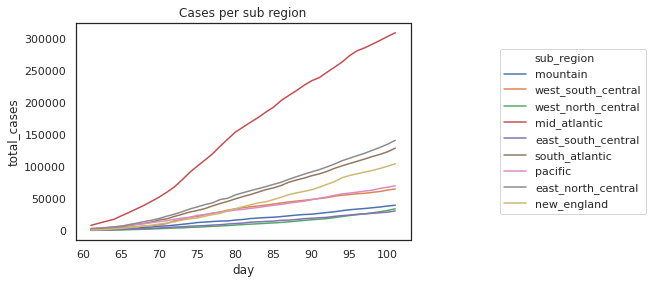

In [ ]:
sns.lineplot(x='day',y='total_cases',data=us_cum_data_df, hue = 'sub_region').set(title='Cases per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

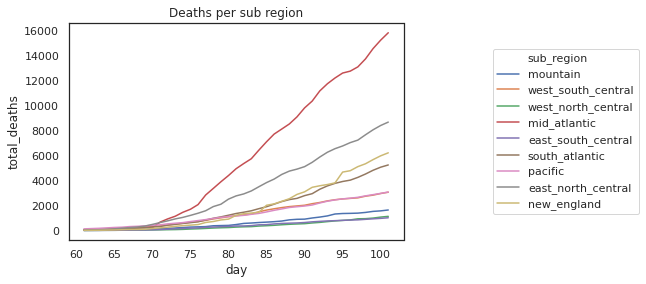

In [ ]:
sns.lineplot(x='day',y='total_deaths',data=us_cum_data_df, hue = 'sub_region').set(title='Deaths per sub region')
plt.legend(loc='center left', bbox_to_anchor=(1.25,0.5),ncol=1)

##Relationships by state


Since there are only 9 different sub regions, I thought it would also be interesting to examine how different states are doing with the Corona Virus because each state is dealing with it in their own way. Let us now look at relationships by grouping by states. We will only look at the current totals and see if some states are handling the pandemic better than others. 

In [ ]:

query = '''select state, sum(daily_cases) as total_cases, 
            sum(daily_deaths) as total_deaths 
            from us_daily_sdf 
            group by state
            order by total_cases DESC
             '''

us_total_sdf = spark.sql(query)

us_total_sdf.show(51)

+--------------------+-----------+------------+
|               state|total_cases|total_deaths|
+--------------------+-----------+------------+
|            New York|   138624.0|      5640.0|
|          New Jersey|   120607.0|      7538.0|
|       Massachusetts|    63885.0|      3709.0|
|            Illinois|    55692.0|      2455.0|
|          California|    52026.0|      2124.0|
|        Pennsylvania|    49579.0|      2635.0|
|            Michigan|    40682.0|      3821.0|
|             Florida|    34720.0|      1314.0|
|               Texas|    29686.0|       840.0|
|           Louisiana|    28648.0|      1927.0|
|         Connecticut|    28393.0|      2337.0|
|             Georgia|    25774.0|      1155.0|
|            Maryland|    23472.0|      1080.0|
|                Ohio|    18743.0|      1003.0|
|             Indiana|    18630.0|      1062.0|
|            Virginia|    16900.0|       581.0|
|            Colorado|    15593.0|       817.0|
|          Washington|    14560.0|      

Below is a plot of total Covid-19 Cases for each state on May 1st. As we can see it appears that all the states in the mid atlantic region are close to the top which would confirm what our data above was suggesting. This graph does  a good job of showing which states have the highest cases as well as deaths.<h5> 


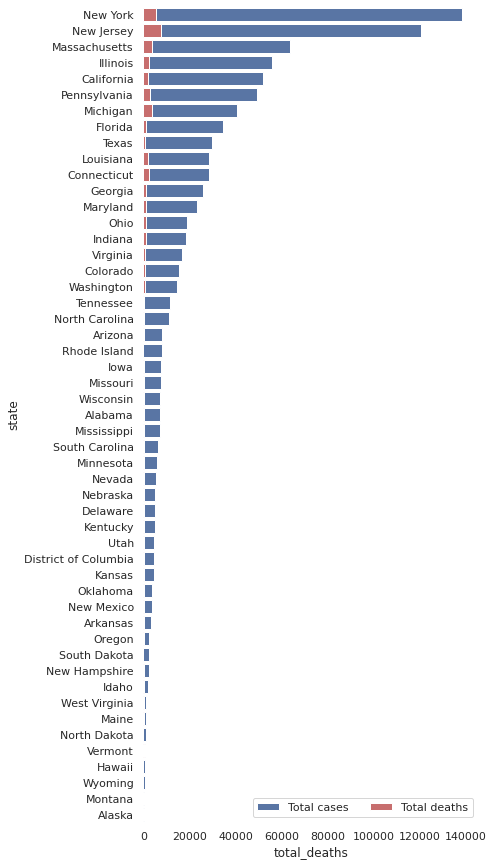

In [ ]:
# make horizantal plot of this

us_total_df = us_total_sdf.toPandas()

f, ax = plt.subplots(figsize = (6,15))
sns.barplot(x = 'total_cases', y = 'state', data = us_total_df,
            label = 'Total cases', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'total_deaths', y = 'state', data = us_total_df,
            label = 'Total deaths', color = 'r', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()

Let us see if we can use the data to see if there are any large differences in the quality of treatement between states. We will determine the effectiveness of a state treating Cornona Virus Patients by calculating the total cases divided by the total deaths. 

In [ ]:
for ind, row in us_total_df.iterrows():
  if (us_total_df.at[ind,'total_deaths'] == 0):
    us_total_df.at[ind,'cases_per_death'] = us_total_df.at[ind,'total_cases']
  else:
    us_total_df.at[ind,'cases_per_death'] = us_total_df.at[ind,'total_cases'] / us_total_df.at[ind,'total_deaths'] 


us_total_df.sort_values(by='cases_per_death',ascending=False)
us_total_df


,state,total_cases,total_deaths,cases_per_death
0,New York,138624.0,5640.0,24.578723
1,New Jersey,120607.0,7538.0,15.999867
2,Massachusetts,63885.0,3709.0,17.224319
3,Illinois,55692.0,2455.0,22.685132
4,California,52026.0,2124.0,24.494350
5,Pennsylvania,49579.0,2635.0,18.815560
6,Michigan,40682.0,3821.0,10.646951
7,Florida,34720.0,1314.0,26.423135
8,Texas,29686.0,840.0,35.340476
9,Louisiana,28648.0,1927.0,14.866632


Below we have a dist plot of cases per death for each state. It appears that a majority states have around 25 cases for every death due to Corona. One thing to note is that I had to exclude Rhode Island and Wyoming because they are doing TOO good of a job at reducing deaths. If I left them in the graph, then we would have been too zoomed out to see anything. <h5> 
You can look at the above dataframe to see that Rhode Island actually has **ZERO** deaths due to Corona Virus while Wyoming has only One. I would say that this is particularly impressive for Rhode Island because of its close proximity to New York City. <h5>
 So if you're worried about the Cornona Virus and your safety, I'd suggest moving to one of those two states. 

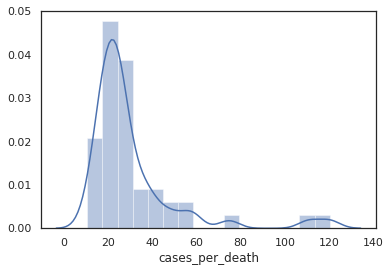

In [ ]:
us_total_df = us_total_df[us_total_df.state != 'Rhode Island']
us_total_df = us_total_df[us_total_df.state != 'Wyoming']

sns.distplot(us_total_df['cases_per_death'])


# Preparing the model
I printed out the table that we will be working with so it's easier to navigate between sections. In this section, we are simply converting the dataframe into one that can be used for machine learning. 

In [ ]:
us_combined_df

,date,fips,day,county,state,sub_region,region,lat,long,cases_nyt,deaths_nyt,cases_jhu,deaths_jhu,recovered,active,daily_cases,daily_deaths,daily_recover,daily_active
0,2020-03-24,1001,63,Autauga,Alabama,east_south_central,south,32.539527,-86.644082,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2020-03-25,1001,64,Autauga,Alabama,east_south_central,south,32.539527,-86.644082,4,0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,2020-03-26,1001,65,Autauga,Alabama,east_south_central,south,32.539527,-86.644082,6,0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,2020-03-27,1001,66,Autauga,Alabama,east_south_central,south,32.539527,-86.644082,6,0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-28,1001,67,Autauga,Alabama,east_south_central,south,32.539527,-86.644082,6,0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97719,2020-04-27,56043,97,Washakie,Wyoming,mountain,west,43.904516,-107.680187,4,0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
97720,2020-04-28,56043,98,Washakie,Wyoming,mountain,west,43.904516,-107.680187,4,0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
97721,2020-04-29,56043,99,Washakie,Wyoming,mountain,west,43.904516,-107.680187,4,0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
97722,2020-04-30,56043,100,Washakie,Wyoming,mountain,west,43.904516,-107.680187,4,0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0


Let us delete the rows that are of no use to us. We figured out some of these rows above but there are some other obvious rows to delete such as region because a given state will always have the same region. We will also only look at rows where new_cases and new_deaths are greater than zero because we will be taking the log of it in order to decrease the range of the data. 

In [ ]:



us_combined_df['weekday'] = us_combined_df['date'].apply(lambda x: x.weekday() + 1)

us_combined_df = us_combined_df.drop(['date','fips','cases_nyt','deaths_nyt', 'recovered','active','daily_recover','daily_active', 'sub_region'], axis=1)


us_daily_sdf = spark.createDataFrame(us_combined_df)

us_daily_sdf.createOrReplaceTempView('us_daily_sdf')

query = ''' select day,weekday,state,sum(cases_jhu) as total_cases, sum(deaths_jhu) as total_deaths, 
            sum(daily_cases) as new_cases, sum(daily_deaths) as new_deaths, avg(lat) as lat, avg(long) as long
            from us_daily_sdf 
            group by day,state,weekday
            order by new_deaths
            ''' 

us_daily_sdf = spark.sql(query)

us_daily_sdf.createOrReplaceTempView('us_daily_sdf2')

query = ''' select * from us_daily_sdf2 
            where new_cases >= 0 and new_deaths >= 0'''

us_daily_sdf2 = spark.sql(query)

us_daily_sdf2.show(15)

+---+-------+--------------+-----------+------------+---------+----------+------------------+-------------------+
|day|weekday|         state|total_cases|total_deaths|new_cases|new_deaths|               lat|               long|
+---+-------+--------------+-----------+------------+---------+----------+------------------+-------------------+
| 66|      5| West Virginia|       76.0|         0.0|     25.0|       0.0| 39.00674909714286| -80.59346260857143|
| 75|      7| New Hampshire|      617.0|         3.0|     77.0|       0.0|      43.478972876| -71.57765670500001|
|101|      5| New Hampshire|     2295.0|        60.0|    152.0|       0.0|      43.478972876| -71.57765670500001|
| 82|      7|  Rhode Island|     1700.0|         3.0|      0.0|       0.0|      41.655142106|      -71.464105098|
| 62|      1|          Utah|      244.0|         1.0|     82.0|       0.0| 40.27946108545455|-112.22638770000002|
| 64|      3|       Montana|       65.0|         0.0|     20.0|       0.0| 46.7649579923

Let us now take the log of all the numeric columns

In [ ]:
us_daily_df = us_daily_sdf2.toPandas()
us_daily_df['total_cases'] = np.log(us_daily_df['total_cases'] + 1)
us_daily_df['total_deaths'] = np.log(us_daily_df['total_deaths'] + 1)
us_daily_df['new_cases'] = np.log(us_daily_df['new_cases'] + 1)
us_daily_df['new_deaths'] = np.log(us_daily_df['new_deaths'] + 1)

Let us now convert the categorical columns by one hot encoding them

In [ ]:
us_daily_df['weekday'] = us_daily_df['weekday'].astype('category')
us_daily_df['state'] = us_daily_df['state'].astype('category')

us_daily_df = pd.get_dummies(us_daily_df, columns=['weekday'])
us_daily_df = pd.get_dummies(us_daily_df, columns=['state'])

us_daily_df

,day,total_cases,total_deaths,new_cases,new_deaths,lat,long,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_District of Columbia,state_Florida,state_Georgia,state_Hawaii,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New Hampshire,state_New Jersey,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,82,7.438972,1.386294,0.000000,0.000000,41.655142,-71.464105,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,85,5.662960,0.693147,1.791759,0.000000,43.096465,-107.380512,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,98,6.285998,0.693147,2.833213,0.000000,43.096465,-107.380512,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,82,8.427050,4.499810,5.379897,0.000000,35.613574,-79.387042,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,64,4.189655,0.000000,3.044522,0.000000,46.764958,-111.427874,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,100,11.679922,8.885856,7.835184,6.126869,40.286441,-74.622450,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2067,77,11.050890,7.218910,8.121480,6.133398,42.705002,-75.607907,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2068,90,11.624699,8.283999,7.905073,6.242223,42.705002,-75.607907,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2069,92,11.460263,8.546946,8.622634,6.447306,40.286441,-74.622450,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Split data into test and train sets

In [ ]:
# create features and labels
label = us_daily_df['new_cases']
features = us_daily_df.drop(['new_cases', 'new_deaths'], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.20, random_state=42)



##PCA 
Let Us now use perform PCA to reduce the amount of features that our model will have. 

[0.04947667 0.03156709 0.02990031 0.01979266 0.01934088 0.01921163
 0.01916648 0.01889852 0.01879529 0.0167364  0.01649039 0.01624947
 0.01623328 0.01623029 0.01622233 0.01622158 0.01621915 0.01621735
 0.01621466 0.01621296 0.01621025 0.01620947 0.0162073  0.01620515
 0.01620424 0.01620382 0.01620067 0.01619949 0.01619863 0.0161973
 0.0161942  0.01619292 0.0161917  0.01619094 0.01618846 0.01618484
 0.01618093 0.01618024 0.0161759  0.01617369 0.01617325 0.0161716
 0.0161692  0.01616888 0.01616679 0.01615901 0.01615555 0.01615263
 0.01614653 0.01614437 0.01593855 0.01574857 0.01565758 0.01565075
 0.01539104 0.01535926 0.01443785 0.00055569 0.00036121 0.00000284
 0.00000129 0.         0.        ]


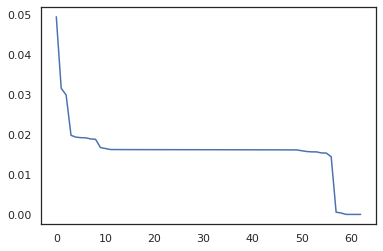

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
pca = PCA(n_components = 63)
pca.fit(x_train)
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)
plt.figure()


plt.plot(np.arange(63),pca.explained_variance_ratio_)


In [ ]:
# let us now transform our data set into the PCA one 

pca = PCA(n_components = 53)

x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)






# Linear Regression

We will now perform Standard Linear Regression on our model after adjusting the dataframe by doing PCA. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

regr_model = linear_model.LinearRegression()
regr_model.fit(x_train, y_train)
y_pred = regr_model.predict(x_test)
y_train_pred = regr_model.predict(x_train)
test_score = np.sqrt(mean_squared_error(y_test, y_pred))
train_score = np.sqrt(mean_squared_error(y_train_pred, y_train))
print(train_score)
print(test_score)
regr_model.score(x_test, y_test)



0.9801030064014631
14.774355747125385


-57.355291841368896

# Random Forest

We will now see how a random forest model will due on our dataset. To choose the parameters for it, we will use GridSearchCV. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()
parameters = {'n_estimators':[70,80,90,100,110,120],'max_depth':[60,70,80,90,100,110]}  
clf = GridSearchCV(estimator, parameters, n_jobs = -1)
clf.fit(x_train,y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

As we can see the best parameters for our data were...

In [ ]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_.score(x_test,y_test))



{'max_depth': 70, 'n_estimators': 120}
0.7151008376909878
-0.3614752892975106


In [ ]:
# Your code goes here
import sklearn.metrics


rando = RandomForestRegressor(n_estimators=120, max_depth=70, n_jobs=-1)
rando = rando.fit(x_train,y_train)
y_pred = rando.predict(x_test)
test_score = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_score)
print(rando.score(x_test, y_test))


2.2560148993834677
-0.3606520123640855


We can see that our Random Forest model performs much better on both the test and training data sets when compared to the Linear Regression Model. This is most likely due to how random the changes of daily_cases per state seem to be as well as the incosistencies in reporting the cases. Random Forest can do a better job of capturing that because Linear Regression would obviously work best for linear data. 

# Description of Challenges

Some challenges that I had with this project would be that I didn't exactly know what to do with the data that wasn't exactly perfect. The Corona Virus dataset is already not that big so I hesitated with deleting more data than I should. Another thing that was challenging for me was trying to think of relationships between the features that didn't seem obvious as well as just finding a general sense of direction with the project. Starting with a blank notebook and having to figure out what to do at the beginning was probably the hardest thing for me.  

# Next Steps

There are many potential next steps that you could do with this dataset because it is getting added to every day. As more data arrives, you could potentially start analyzing the world dataset to see if there are similar trends between different countries in the world as between different states in America. 
<h5>Additionally, as states start to lessen their quarantine restrictions, you could visualize the data to see if there is a noticable jump in COVID-19 cases in states where there are no longer stay at home orders. Other possible avenues of research would include getting a separate dataframe of population data for countries and states and then actually determining whether or not latitude or population density plays any significant factor in the virus spread. 
